In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

from itertools import repeat
from torch.multiprocessing import Pool
import time


from scipy.signal import find_peaks

def do_rollout_from_state(env, policy, init_state, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 5, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        #obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act = policy(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_explore_rollout(args):
    force, init_state, trial_num = args
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
    
    env.seed(trial_num)
    obs, acts, rews, x_list = do_push_rollout_from_state(env, mdim_policy, init_state, force)    
    
    return None, np.asarray(obs)

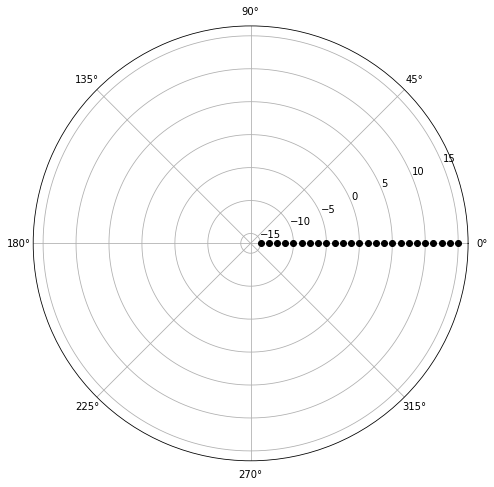

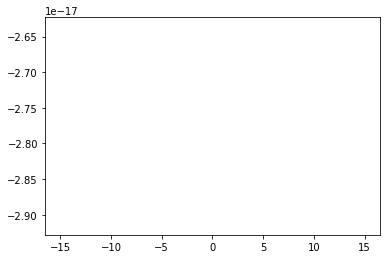

In [2]:
n_forces = 25

#angs = np.random.uniform(0,2*np.pi,n_forces)
mags = np.random.uniform(5,15,n_forces) 

angs = np.zeros(n_forces)
mags = np.linspace(-15,15, n_forces)

forces_x = np.cos(angs)*mags
forces_y = np.sin(angs)*mags

plt.figure(figsize=(8,8))
plt.polar(angs, mags, 'o',color='k')
#plt.xlabel('x')
#plt.ylabel('y')

force_iter = [np.array([fx,fy]) for fy,fx in zip(forces_x, forces_y)]

plt.figure()
plt.scatter(forces_x, forces_y)

In [12]:
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,3,4,5,6]
# rollout_length = 1000
# lookback_length = 50

#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,2,3,4,5,6,7,8,9]
# rollout_length = 100
# lookback_length = 5

# def fail_cond(ob):
#     return not (-.25 < ob[1] < .25)

#===============================
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short

seeds = [0,1,2,3,4,5,6,7,8,9]
deltas = [.4,.3,.2,.1]
#seeds = [7,8,9]
step_length = 100
# ===============================


env = gym.make(env_name)
#data = torch.load(f"./data_noise1/{env_name}.xr")
data = torch.load(f"./data17/{env_name}.xr")

init_policy_dict = data.policy_dict

#data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
data = torch.load(f"./data_mcshdim4/{env_name}.xr")

policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

# Construct Initial Mesh

In [15]:
import pandas as pd
mesh_sizes  = pd.DataFrame(np.zeros((len(seeds), len(deltas))), columns=deltas)
class MeshBox:
    def __init__(self, state, iden, freq, trans_list):
        self.state = state
        self.id = iden
        self.freq = freq
        self.trans_list = trans_list

for delta in deltas:
    for seed in seeds:
        iden_policy = policy_dict[post_names[0]][seed]
        mdim_policy = policy_dict[post_names[0]][seed]

        iden_mesh = BoxMesh(delta); iden_l = []
        mdim_mesh = BoxMesh(delta); mdim_l = []


        fail_state = np.ones_like(env.reset())*100
        fail_id = 0
        mdim_mesh[fail_state] = MeshBox(fail_state, 0, 1, [])

        
        for _ in range(20):
            mdim_obs, mdim_acts, mdim_rews, _ = do_long_rollout(env,mdim_policy, ep_length=1000)
            peak_idx,_ = find_peaks(mdim_obs[:,0], distance=20)

            for o in mdim_obs[peak_idx[2:],:]:
                key = (o - mdim_policy.state_means)/mdim_policy.state_std

                if key in mdim_mesh:
                    mdim_mesh[key].freq +=1
                else:
                    mdim_mesh[key] =  MeshBox(o, len(mdim_mesh), 1, [])

        #for i in peak_idx:
        #    plt.axvline(x=i, color='r')

        start = time.time()
        keys = list(mdim_mesh.keys())[1:]
        i = 0 
        with Pool() as pool:
            for key in keys:    
                i+=1 

                init_state = mdim_mesh[key].state
                state_iter = repeat(init_state, n_forces)
                seeds_iter = range(i*n_forces, i*n_forces+n_forces)


                for j, res in enumerate(pool.imap(do_explore_rollout, zip(force_iter, state_iter, seeds_iter))):
                    _ , mdim_obs = res

                    peak_idx,_ = find_peaks(mdim_obs[:,0], distance=20)

                    if len(peak_idx) != 1 or fail_cond(mdim_obs[:peak_idx[0]]).any():
                        new_id = fail_id
                        mdim_mesh[fail_state].freq +=1
                    else:
                        mdim_key = ((mdim_obs[peak_idx,:] - np.array(mdim_policy.state_means))/np.array(mdim_policy.state_std)).squeeze()
                        if mdim_key in mdim_mesh:
                            new_id = mdim_mesh[mdim_key].id
                            mdim_mesh[mdim_key].freq += 1
                        else:
                            mdim_mesh[mdim_key] = MeshBox(mdim_obs[peak_idx, :].squeeze(), len(mdim_mesh), 1, [])
                            new_id = len(mdim_mesh)-1
                            keys.append(mdim_mesh.__keytransform__(mdim_key))



                    mdim_mesh[key].trans_list.append(new_id)

                #if i % 1000 == 0:
                #    print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")

        mesh_sizes[delta][seed] = len(mdim_mesh)
        print(f"|{delta} | {seed} | {len(mdim_mesh)} |")
        #mesh_list.append(len(mdim_mesh))
        #import dill
        #with  open(f"meshes_1/hopper_s{seed}_mdim.pkl", 'wb') as file:
        #    dill.dump(mdim_mesh, file)

           
# k_mat = np.zeros((len(mdim_mesh)-1,11))
# i = 0
# for box in list(mdim_mesh.values())[1:]:
#     k_mat[i,:] = box.state
#     i+=1

# from scipy.io import savemat
# savemat("./meshes/initial_poincare_states.mat",{"states":k_mat})

|0.4 | 0 | 53 |
|0.4 | 1 | 70 |
|0.4 | 2 | 41 |
|0.4 | 3 | 101 |
|0.4 | 4 | 20 |
|0.4 | 5 | 106 |
|0.4 | 6 | 55 |
|0.4 | 7 | 102 |
|0.4 | 8 | 31 |
|0.4 | 9 | 70 |
|0.3 | 0 | 50 |
|0.3 | 1 | 161 |
|0.3 | 2 | 84 |
|0.3 | 3 | 188 |
|0.3 | 4 | 26 |
|0.3 | 5 | 38 |
|0.3 | 6 | 447 |
|0.3 | 7 | 170 |
|0.3 | 8 | 39 |
|0.3 | 9 | 87 |
|0.2 | 0 | 111 |
|0.2 | 1 | 341 |
|0.2 | 2 | 167 |
|0.2 | 3 | 503 |
|0.2 | 4 | 61 |
|0.2 | 5 | 577 |
|0.2 | 6 | 198 |
|0.2 | 7 | 593 |
|0.2 | 8 | 117 |
|0.2 | 9 | 224 |
|0.1 | 0 | 809 |
|0.1 | 1 | 2533 |
|0.1 | 2 | 1856 |
|0.1 | 3 | 4537 |
|0.1 | 4 | 372 |
|0.1 | 5 | 4808 |
|0.1 | 6 | 9196 |
|0.1 | 7 | 3946 |
|0.1 | 8 | 387 |
|0.1 | 9 | 1308 |


In [16]:
mesh_sizes.to_csv('./mesh_sizes/iden_25.csv')

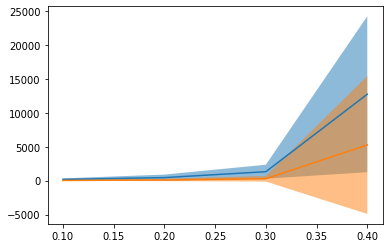

In [105]:
def plot_mean_std(x_data, data):
    means = np.array(data.mean(axis=0))
    stds = np.array(data.std(axis=0))
    plt.plot(x_data, means)
    plt.fill_between(x_data, (means-stds), (means+stds), alpha=.5)

plot_mean_std(deltas , mesh_sizes)
plot_mean_std(deltas , mesh_sizes2)



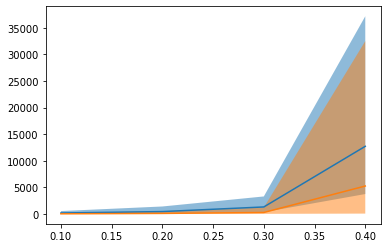

In [109]:
def plot_mean_minmax(x_data, data):
    means = np.array(data.mean(axis=0))
    mins = np.array(data.min(axis=0))
    maxs = np.array(data.max(axis=0))
    
    plt.plot(x_data, means)
    plt.fill_between(x_data, (mins), (maxs), alpha=.5)

plot_mean_minmax(deltas , mesh_sizes)
plot_mean_minmax(deltas , mesh_sizes2)


In [ ]:
#plt.spy(T, markersize=4, figsize=(15,20))
fig, ax = plt.subplots(1, figsize=(15,15))
ax.spy(T, markersize=1)

In [ ]:
from scipy.sparse.linalg import eigs
w, v = eigs(T)
print(w)

print(-1/np.log(w[1]))

In [ ]:
import dill
#with 
mdim_mesh = dill.load(open("meshes/hopper0_mdim_noise.pkl", 'rb'))
# with  open("meshes/hopper0_iden.pkl", 'wb') as file:
#   dill.dump(mdim_mesh, file)

In [ ]:
T[:,0]

In [ ]:
for m in mesh